# Notebook 05 - Modélisation des émotions (GoEmotions)

# 1 - Imports & configuration

In [1]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import mlflow
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

from src.utils.tree_utils import afficher_arborescence
from src.pipeline_emotions import run_emotion_pipeline
from src.utils.visualization_utils import plot_normalized_metrics

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0519 11:58:24.746000 21052 venv_P9_V2\Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


# 2 - Arborescence du projet

In [2]:
print("📂 Arborescence du projet :")
afficher_arborescence('..', niveau_max = 1)

📂 Arborescence du projet :
├── %USERPROFILE%.git-credentials
├── .coverage
├── .git
│   ├── COMMIT_EDITMSG
│   ├── HEAD
│   ├── config
│   ├── description
│   ├── hooks
│   ├── index
│   ├── info
│   ├── logs
│   ├── objects
│   ├── refs
├── .github
│   ├── workflows
├── .gitignore
├── .history
│   ├── .github
│   ├── .gitignore_20250515103945
│   ├── .gitignore_20250515142538
│   ├── .gitignore_20250515153648
│   ├── app_20250515074448.py
│   ├── app_20250515135249.py
│   ├── app_20250515135349.py
│   ├── app_20250515143110.py
│   ├── app_20250518103623.py
│   ├── app_20250518103849.py
│   ├── app_20250518105122.py
│   ├── requirements_20250515104459.txt
│   ├── requirements_20250515143348.txt
│   ├── results
│   ├── src
│   ├── tests
├── .pytest_cache
│   ├── .gitignore
│   ├── CACHEDIR.TAG
│   ├── README.md
│   ├── v
├── .vscode
│   ├── settings.json
├── Procfile
├── README.md
├── __pycache__
│   ├── arborescence.cpython-310.pyc
├── app.py
├── arborescence.py
├── check_trainer.py
├─

# 3 - Chargement du dataset GoEmotions

In [3]:
data_path = os.path.join("..", "data", "raw", "goemotions.csv")
df = pd.read_csv(data_path)

print("✅ Dimensions du dataset :", df.shape)
# df.head()

✅ Dimensions du dataset : (211225, 37)


## 3.1 - Création de la colonne "labels" multi-indexée (0 à 27)

In [4]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]  # colonnes d’émotions (28 colonnes après les métadonnées)
df['labels'] = df[emotion_cols].apply(lambda row: [i for i, v in enumerate(row) if v == 1], axis=1)

In [5]:
print("✅ Dimensions du dataset :", df.shape)
print("📊 Nombre moyen d’émotions par tweet :", df['labels'].apply(len).mean())
df[['text', 'labels']].head()

✅ Dimensions du dataset : (211225, 38)
📊 Nombre moyen d’émotions par tweet : 1.1813421706710854


,text,labels
0,That game hurt.,[25]
1,>sexuality shouldn’t be a grouping category I...,[]
2,"You do right, if you don't care then fuck 'em!",[27]
3,Man I love reddit.,[18]
4,"[NAME] was nowhere near them, he was by the Fa...",[27]


# 4 - Statistiques de base

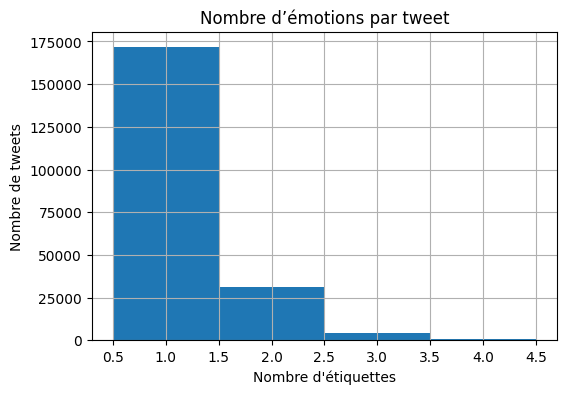

In [6]:
df['n_emotions'] = df['labels'].apply(len)
df['n_emotions'].hist(bins=range(1, 6), align='left', figsize=(6, 4))
plt.title("Nombre d’émotions par tweet")
plt.xlabel("Nombre d'étiquettes")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.show()

## 4.1 - Répartition des émotions globales

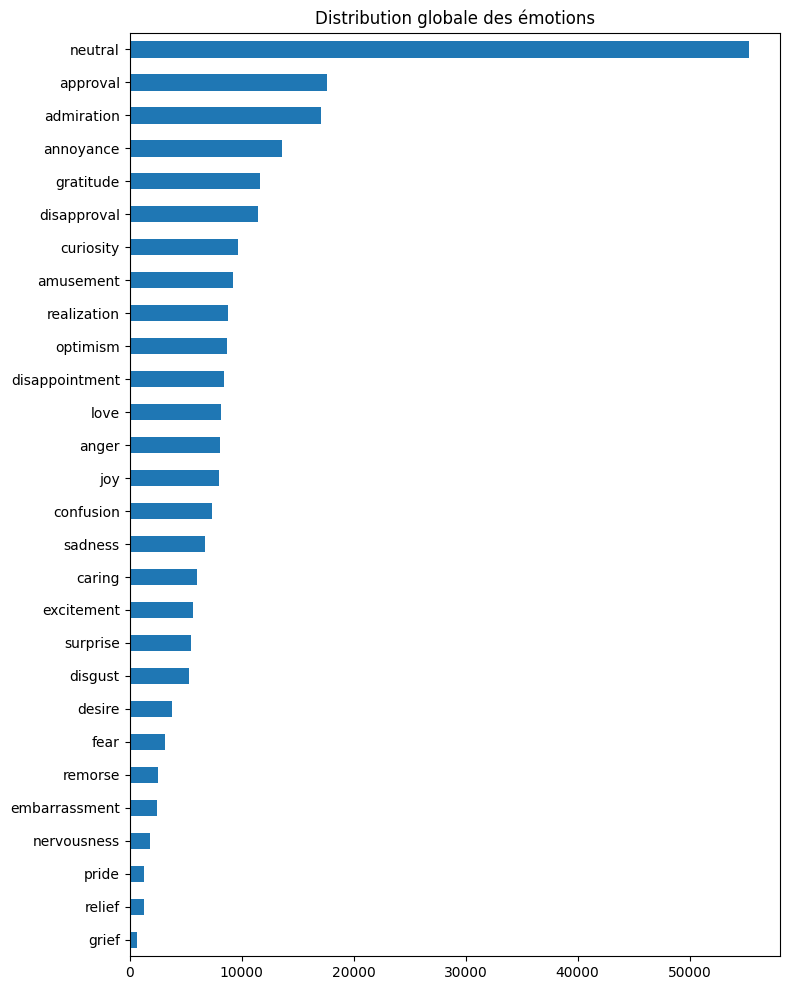

In [7]:
df[emotion_cols].sum().sort_values().plot(kind="barh", figsize=(8, 10))
plt.title("Distribution globale des émotions")
plt.tight_layout()
plt.show()

# 5 - Nuage de mots

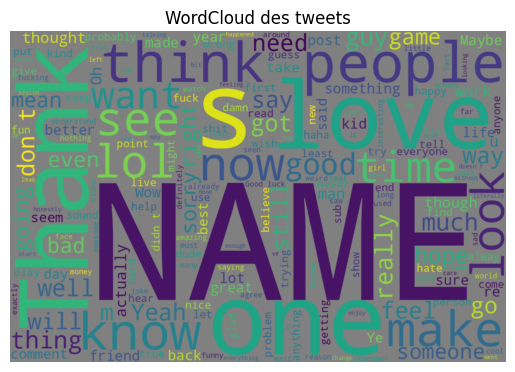

In [8]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, background_color = "grey").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des tweets")
plt.show()

# 6 - Entraînement du modèle via pipeline sur GoEmotions (multi-label à 28 classes)

Un modèle ELECTRA est entraîné pour la tâche d’analyse fine des émotions à partir du dataset **GoEmotions**, contenant **28 étiquettes émotionnelles** (colère, joie, peur, admiration, etc.).

Contrairement à une tâche de classification binaire, chaque tweet peut exprimer **plusieurs émotions simultanément**. Il s’agit donc d’un problème de **classification multi-label**, nécessitant une adaptation spécifique du modèle, de la fonction de perte et des métriques d’évaluation.

---

### ⚙️ Paramétrage du pipeline `run_emotion_pipeline()`

- ✅ **Modèle utilisé** : `electra-small-discriminator`, chargé en **local** (dossier `models/hf_assets/`)
- ✅ **Tokenization** : via `AutoTokenizer`, avec padding automatique et troncature (`max_length`)
- ✅ **Head de classification** :
  - `num_labels = 28` (une sortie par émotion)
  - `problem_type = "multi_label_classification"` (sortie `sigmoid` par étiquette)

---

### 🧠 Données utilisées

- ✅ **Source** : fichier `goemotions.csv` (28 colonnes binaires d’émotions)
- ✅ **Réduction** :
  - échantillon aléatoire à **50 000 lignes** (hors `test_mode`)
- ✅ **Suréchantillonnage léger** :
  - les classes présentes moins de `150 fois` sont **dupliquées avec remplacement**
  - permet une meilleure représentativité des émotions rares sans écrasement des autres classes
- ✅ **Encodage des labels** :
  - fusion des colonnes binaires en vecteurs `labels` multi-labels `float32`

---

### ⚖️ Gestion des déséquilibres

- ✅ Calcul de **poids de classe** (`class_weights`) :
  - pondération logarithmique : `log1p(1 / fréquence)`
  - plus les classes sont rares, plus elles sont pondérées
- ✅ Intégration dans la loss :
  - `BCEWithLogitsLoss(pos_weight=class_weights)`
- ✅ Enregistrement des poids dans MLflow (`class_weight_nom_emotion`)

---

### 🧪 Paramètres d’entraînement

- ✅ Entraînement via `Trainer` avec GPU (vérification CUDA)
- ✅ Hyperparamètres :
  - `batch_size = 16` (train) / `32` (eval)
  - `num_train_epochs = 5`
  - `learning_rate = 3e-5`, `weight_decay = 0.01`
  - `warmup_ratio = 0.1`, `lr_scheduler_type = "cosine"`
  - `fp16 = True` (accélération GPU en mode mixed precision)
- ✅ Callbacks :
  - `EarlyStoppingCallback(patience=2)`
  - `PrinterCallback` supprimé pour limiter les logs excessifs

---

### 📈 Évaluation et métriques

- ✅ **Seuil de prédiction** : `sigmoid > 0.25` (valeur fixée dans `THRESHOLD`)
- ✅ **Métriques utilisées** :
  - `f1_score` (micro-avg)
  - `accuracy_score`
- ✅ **Échantillon d’évaluation** : les **100 premiers exemples** du dataset

---

### 📦 MLOps et enregistrement via MLflow

- ✅ **Artefacts loggés** :
  - modèle (`model.save_pretrained(...)`)
  - tokenizer (`tokenizer.save_pretrained(...)`)
  - métriques `f1` et `accuracy` dans `metrics.pkl`
- ✅ **Tracking MLflow** :
  - tous les hyperparamètres (`training_args.to_dict()`)
  - métriques globales
  - `class_weights` par classe

---

> 🔁 Le pipeline est relançable à volonté :
> - `force_retrain = True` pour forcer un nouvel entraînement complet
> - Sinon, reprise automatique depuis le dernier checkpoint détecté
>
> 📂 Tous les résultats sont enregistrés dans `models/emotions/`, indépendamment du modèle binaire de classification sentimentale.


In [9]:
model, tokenizer, metrics = run_emotion_pipeline(force_retrain = True, test_mode=False)

Some weights of the model checkpoint at c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\models\hf_assets\electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkp

{'loss': 0.749, 'learning_rate': 1.923076923076923e-06, 'epoch': 0.03}


  1%|▏         | 200/15595 [01:31<1:56:10,  2.21it/s]

{'loss': 0.7374, 'learning_rate': 3.846153846153846e-06, 'epoch': 0.06}


  2%|▏         | 300/15595 [02:16<1:55:13,  2.21it/s]

{'loss': 0.7104, 'learning_rate': 5.76923076923077e-06, 'epoch': 0.1}


  3%|▎         | 400/15595 [03:02<1:55:07,  2.20it/s]

{'loss': 0.6626, 'learning_rate': 7.692307692307692e-06, 'epoch': 0.13}


  3%|▎         | 500/15595 [03:47<1:54:06,  2.20it/s]

{'loss': 0.5929, 'learning_rate': 9.615384615384616e-06, 'epoch': 0.16}


  4%|▍         | 600/15595 [04:32<1:52:41,  2.22it/s]

{'loss': 0.5062, 'learning_rate': 1.153846153846154e-05, 'epoch': 0.19}


  4%|▍         | 700/15595 [05:18<1:53:08,  2.19it/s]

{'loss': 0.4377, 'learning_rate': 1.3461538461538462e-05, 'epoch': 0.22}


  5%|▌         | 800/15595 [06:03<1:51:20,  2.21it/s]

{'loss': 0.3992, 'learning_rate': 1.5384615384615384e-05, 'epoch': 0.26}


  6%|▌         | 900/15595 [06:48<1:51:23,  2.20it/s]

{'loss': 0.3815, 'learning_rate': 1.7307692307692306e-05, 'epoch': 0.29}


  6%|▋         | 1000/15595 [07:34<1:50:14,  2.21it/s]

{'loss': 0.3752, 'learning_rate': 1.923076923076923e-05, 'epoch': 0.32}


  7%|▋         | 1100/15595 [08:19<1:49:43,  2.20it/s]

{'loss': 0.3769, 'learning_rate': 2.1153846153846157e-05, 'epoch': 0.35}


  8%|▊         | 1200/15595 [09:04<1:48:23,  2.21it/s]

{'loss': 0.361, 'learning_rate': 2.307692307692308e-05, 'epoch': 0.38}


  8%|▊         | 1300/15595 [09:50<1:47:37,  2.21it/s]

{'loss': 0.3755, 'learning_rate': 2.5e-05, 'epoch': 0.42}


  9%|▉         | 1400/15595 [10:35<1:48:35,  2.18it/s]

{'loss': 0.3702, 'learning_rate': 2.6923076923076923e-05, 'epoch': 0.45}


 10%|▉         | 1500/15595 [11:21<1:46:24,  2.21it/s]

{'loss': 0.3755, 'learning_rate': 2.884615384615385e-05, 'epoch': 0.48}


 10%|█         | 1600/15595 [12:06<1:45:46,  2.21it/s]

{'loss': 0.3683, 'learning_rate': 2.9999398752537962e-05, 'epoch': 0.51}


 11%|█         | 1700/15595 [12:51<1:45:04,  2.20it/s]

{'loss': 0.3614, 'learning_rate': 2.9992635272122454e-05, 'epoch': 0.55}


 12%|█▏        | 1800/15595 [13:37<1:43:55,  2.21it/s]

{'loss': 0.353, 'learning_rate': 2.9978360151913107e-05, 'epoch': 0.58}


 12%|█▏        | 1900/15595 [14:22<1:43:14,  2.21it/s]

{'loss': 0.3572, 'learning_rate': 2.9956580544058907e-05, 'epoch': 0.61}


 13%|█▎        | 2000/15595 [15:07<1:42:51,  2.20it/s]

{'loss': 0.3643, 'learning_rate': 2.992730736062208e-05, 'epoch': 0.64}


 13%|█▎        | 2100/15595 [15:53<1:42:28,  2.19it/s]

{'loss': 0.349, 'learning_rate': 2.989055526811092e-05, 'epoch': 0.67}


 14%|█▍        | 2200/15595 [16:38<1:40:54,  2.21it/s]

{'loss': 0.3433, 'learning_rate': 2.9846342680131553e-05, 'epoch': 0.71}


 15%|█▍        | 2300/15595 [17:23<1:39:37,  2.22it/s]

{'loss': 0.3489, 'learning_rate': 2.9794691748162295e-05, 'epoch': 0.74}


 15%|█▌        | 2400/15595 [18:09<1:39:53,  2.20it/s]

{'loss': 0.3564, 'learning_rate': 2.97356283504553e-05, 'epoch': 0.77}


 16%|█▌        | 2500/15595 [18:54<1:38:48,  2.21it/s]

{'loss': 0.3419, 'learning_rate': 2.9669182079070974e-05, 'epoch': 0.8}


 17%|█▋        | 2600/15595 [19:40<1:38:01,  2.21it/s]

{'loss': 0.3307, 'learning_rate': 2.95953862250517e-05, 'epoch': 0.83}


 17%|█▋        | 2700/15595 [20:25<1:36:44,  2.22it/s]

{'loss': 0.3303, 'learning_rate': 2.951427776174229e-05, 'epoch': 0.87}


 18%|█▊        | 2800/15595 [21:10<1:36:08,  2.22it/s]

{'loss': 0.3316, 'learning_rate': 2.9425897326265552e-05, 'epoch': 0.9}


 19%|█▊        | 2900/15595 [21:56<1:35:53,  2.21it/s]

{'loss': 0.3276, 'learning_rate': 2.9330289199162165e-05, 'epoch': 0.93}


 19%|█▉        | 3000/15595 [22:41<1:34:56,  2.21it/s]

{'loss': 0.3249, 'learning_rate': 2.922750128220517e-05, 'epoch': 0.96}


 20%|█▉        | 3100/15595 [23:26<1:35:03,  2.19it/s]

{'loss': 0.3244, 'learning_rate': 2.9117585074400145e-05, 'epoch': 0.99}


 20%|██        | 3119/15595 [23:35<1:28:54,  2.34it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do no

{'eval_loss': 0.32606810331344604, 'eval_f1_micro': 0.2844, 'eval_f1_macro': 0.1322, 'eval_f1_weighted': 0.2748, 'eval_accuracy': 0.14, 'eval_hamming_loss': 0.1114, 'eval_log_loss': 3.2379, 'eval_roc_auc_micro': 0.815, 'eval_pr_auc_macro': 0.2036, 'eval_coverage_error': 6.15, 'eval_lrap': 0.534, 'eval_runtime': 0.9259, 'eval_samples_per_second': 108.006, 'eval_steps_per_second': 4.32, 'epoch': 1.0}


 21%|██        | 3200/15595 [24:13<1:33:58,  2.20it/s]

{'loss': 0.3238, 'learning_rate': 2.9000595646183036e-05, 'epoch': 1.03}


 21%|██        | 3300/15595 [24:58<1:33:31,  2.19it/s]

{'loss': 0.3096, 'learning_rate': 2.8876591611828685e-05, 'epoch': 1.06}


 22%|██▏       | 3400/15595 [25:44<1:31:35,  2.22it/s]

{'loss': 0.3215, 'learning_rate': 2.8745635100083784e-05, 'epoch': 1.09}


 22%|██▏       | 3500/15595 [26:29<1:31:47,  2.20it/s]

{'loss': 0.3113, 'learning_rate': 2.860779172303901e-05, 'epoch': 1.12}


 23%|██▎       | 3600/15595 [27:14<1:30:51,  2.20it/s]

{'loss': 0.3125, 'learning_rate': 2.8463130543255908e-05, 'epoch': 1.15}


 24%|██▎       | 3700/15595 [28:00<1:30:12,  2.20it/s]

{'loss': 0.3047, 'learning_rate': 2.8311724039165056e-05, 'epoch': 1.19}


 24%|██▍       | 3800/15595 [28:45<1:28:53,  2.21it/s]

{'loss': 0.3098, 'learning_rate': 2.815364806875276e-05, 'epoch': 1.22}


 25%|██▌       | 3900/15595 [29:31<1:28:20,  2.21it/s]

{'loss': 0.3019, 'learning_rate': 2.7988981831554546e-05, 'epoch': 1.25}


 26%|██▌       | 4000/15595 [30:16<1:27:46,  2.20it/s]

{'loss': 0.304, 'learning_rate': 2.7817807828974434e-05, 'epoch': 1.28}


 26%|██▋       | 4100/15595 [31:01<1:26:45,  2.21it/s]

{'loss': 0.2999, 'learning_rate': 2.7640211822949947e-05, 'epoch': 1.31}


 27%|██▋       | 4200/15595 [31:47<1:25:47,  2.21it/s]

{'loss': 0.3012, 'learning_rate': 2.7456282792983478e-05, 'epoch': 1.35}


 28%|██▊       | 4300/15595 [32:32<1:25:35,  2.20it/s]

{'loss': 0.3026, 'learning_rate': 2.7266112891561614e-05, 'epoch': 1.38}


 28%|██▊       | 4400/15595 [33:18<1:25:00,  2.19it/s]

{'loss': 0.306, 'learning_rate': 2.7069797397984696e-05, 'epoch': 1.41}


 29%|██▉       | 4500/15595 [34:03<1:23:42,  2.21it/s]

{'loss': 0.2979, 'learning_rate': 2.6867434670629814e-05, 'epoch': 1.44}


 29%|██▉       | 4600/15595 [34:48<1:22:58,  2.21it/s]

{'loss': 0.293, 'learning_rate': 2.6659126097671106e-05, 'epoch': 1.47}


 30%|███       | 4700/15595 [35:34<1:22:27,  2.20it/s]

{'loss': 0.2882, 'learning_rate': 2.6444976046282022e-05, 'epoch': 1.51}


 31%|███       | 4800/15595 [36:19<1:21:38,  2.20it/s]

{'loss': 0.2976, 'learning_rate': 2.6225091810345104e-05, 'epoch': 1.54}


 31%|███▏      | 4900/15595 [37:04<1:20:47,  2.21it/s]

{'loss': 0.2906, 'learning_rate': 2.599958355669538e-05, 'epoch': 1.57}


 32%|███▏      | 5000/15595 [37:50<1:20:10,  2.20it/s]

{'loss': 0.2947, 'learning_rate': 2.5768564269924373e-05, 'epoch': 1.6}


 33%|███▎      | 5100/15595 [38:35<1:19:52,  2.19it/s]

{'loss': 0.2871, 'learning_rate': 2.553214969577231e-05, 'epoch': 1.64}


 33%|███▎      | 5200/15595 [39:21<1:18:54,  2.20it/s]

{'loss': 0.2906, 'learning_rate': 2.529045828313699e-05, 'epoch': 1.67}


 34%|███▍      | 5300/15595 [40:06<1:17:49,  2.20it/s]

{'loss': 0.2832, 'learning_rate': 2.504361112472827e-05, 'epoch': 1.7}


 35%|███▍      | 5400/15595 [40:52<1:17:19,  2.20it/s]

{'loss': 0.2829, 'learning_rate': 2.4791731896397956e-05, 'epoch': 1.73}


 35%|███▌      | 5500/15595 [41:37<1:16:57,  2.19it/s]

{'loss': 0.2857, 'learning_rate': 2.4534946795175483e-05, 'epoch': 1.76}


 36%|███▌      | 5600/15595 [42:23<1:15:29,  2.21it/s]

{'loss': 0.2734, 'learning_rate': 2.427338447604043e-05, 'epoch': 1.8}


 37%|███▋      | 5700/15595 [43:08<1:14:39,  2.21it/s]

{'loss': 0.2812, 'learning_rate': 2.4007175987463557e-05, 'epoch': 1.83}


 37%|███▋      | 5800/15595 [43:53<1:13:49,  2.21it/s]

{'loss': 0.2838, 'learning_rate': 2.373645470574862e-05, 'epoch': 1.86}


 38%|███▊      | 5900/15595 [44:39<1:13:40,  2.19it/s]

{'loss': 0.2877, 'learning_rate': 2.3461356268207936e-05, 'epoch': 1.89}


 38%|███▊      | 6000/15595 [45:24<1:13:08,  2.19it/s]

{'loss': 0.2895, 'learning_rate': 2.3182018505205082e-05, 'epoch': 1.92}


 39%|███▉      | 6100/15595 [46:09<1:11:44,  2.21it/s]

{'loss': 0.2826, 'learning_rate': 2.2898581371098886e-05, 'epoch': 1.96}


 40%|███▉      | 6200/15595 [46:55<1:11:11,  2.20it/s]

{'loss': 0.2842, 'learning_rate': 2.2611186874123178e-05, 'epoch': 1.99}


 40%|████      | 6238/15595 [47:12<1:05:36,  2.38it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do no

{'eval_loss': 0.292031854391098, 'eval_f1_micro': 0.3318, 'eval_f1_macro': 0.2136, 'eval_f1_weighted': 0.3497, 'eval_accuracy': 0.12, 'eval_hamming_loss': 0.1021, 'eval_log_loss': 2.9215, 'eval_roc_auc_micro': 0.8525, 'eval_pr_auc_macro': 0.3439, 'eval_coverage_error': 5.65, 'eval_lrap': 0.5336, 'eval_runtime': 0.9182, 'eval_samples_per_second': 108.911, 'eval_steps_per_second': 4.356, 'epoch': 2.0}


 40%|████      | 6300/15595 [47:42<1:10:17,  2.20it/s]

{'loss': 0.276, 'learning_rate': 2.2319979005237583e-05, 'epoch': 2.02}


 41%|████      | 6400/15595 [48:27<1:09:22,  2.21it/s]

{'loss': 0.2746, 'learning_rate': 2.202510366598485e-05, 'epoch': 2.05}


 42%|████▏     | 6500/15595 [49:13<1:09:27,  2.18it/s]

{'loss': 0.2735, 'learning_rate': 2.1726708595391e-05, 'epoch': 2.08}


 42%|████▏     | 6600/15595 [49:59<1:08:40,  2.18it/s]

{'loss': 0.2747, 'learning_rate': 2.1424943295944814e-05, 'epoch': 2.12}


 43%|████▎     | 6700/15595 [50:44<1:07:35,  2.19it/s]

{'loss': 0.2834, 'learning_rate': 2.1123024235871313e-05, 'epoch': 2.15}


 44%|████▎     | 6800/15595 [51:31<1:09:30,  2.11it/s]

{'loss': 0.2807, 'learning_rate': 2.0815003565523934e-05, 'epoch': 2.18}


 44%|████▍     | 6900/15595 [52:16<1:06:25,  2.18it/s]

{'loss': 0.272, 'learning_rate': 2.0504069450582508e-05, 'epoch': 2.21}


 45%|████▍     | 7000/15595 [53:02<1:05:19,  2.19it/s]

{'loss': 0.2692, 'learning_rate': 2.019037767587263e-05, 'epoch': 2.24}


 46%|████▌     | 7100/15595 [53:48<1:05:32,  2.16it/s]

{'loss': 0.2681, 'learning_rate': 1.9874085407868047e-05, 'epoch': 2.28}


 46%|████▌     | 7200/15595 [54:34<1:03:55,  2.19it/s]

{'loss': 0.2709, 'learning_rate': 1.9555351115946805e-05, 'epoch': 2.31}


 47%|████▋     | 7300/15595 [55:19<1:03:06,  2.19it/s]

{'loss': 0.2656, 'learning_rate': 1.9234334492994605e-05, 'epoch': 2.34}


 47%|████▋     | 7400/15595 [56:05<1:03:17,  2.16it/s]

{'loss': 0.2794, 'learning_rate': 1.891119637539515e-05, 'epoch': 2.37}


 48%|████▊     | 7500/15595 [56:50<1:01:38,  2.19it/s]

{'loss': 0.27, 'learning_rate': 1.8586098662447608e-05, 'epoch': 2.4}


 49%|████▊     | 7600/15595 [57:35<59:31,  2.24it/s]  

{'loss': 0.2767, 'learning_rate': 1.8259204235251465e-05, 'epoch': 2.44}


 49%|████▉     | 7700/15595 [58:19<59:23,  2.22it/s]  

{'loss': 0.2635, 'learning_rate': 1.7930676875099545e-05, 'epoch': 2.47}


 50%|█████     | 7800/15595 [59:05<1:00:23,  2.15it/s]

{'loss': 0.2719, 'learning_rate': 1.7600681181419984e-05, 'epoch': 2.5}


 51%|█████     | 7900/15595 [59:51<59:49,  2.14it/s]  

{'loss': 0.2741, 'learning_rate': 1.7269382489308262e-05, 'epoch': 2.53}


 51%|█████▏    | 8000/15595 [1:00:37<58:43,  2.16it/s]

{'loss': 0.2703, 'learning_rate': 1.6936946786690736e-05, 'epoch': 2.56}


 52%|█████▏    | 8100/15595 [1:01:23<57:28,  2.17it/s]

{'loss': 0.2633, 'learning_rate': 1.660354063116101e-05, 'epoch': 2.6}


 53%|█████▎    | 8200/15595 [1:02:08<55:37,  2.22it/s]

{'loss': 0.2698, 'learning_rate': 1.626933106653092e-05, 'epoch': 2.63}


 53%|█████▎    | 8300/15595 [1:02:54<55:08,  2.20it/s]

{'loss': 0.2696, 'learning_rate': 1.5934485539137918e-05, 'epoch': 2.66}


 54%|█████▍    | 8400/15595 [1:03:39<54:34,  2.20it/s]

{'loss': 0.2647, 'learning_rate': 1.5599171813950793e-05, 'epoch': 2.69}


 55%|█████▍    | 8500/15595 [1:04:25<53:08,  2.22it/s]

{'loss': 0.2697, 'learning_rate': 1.5263557890515712e-05, 'epoch': 2.73}


 55%|█████▌    | 8600/15595 [1:05:10<52:42,  2.21it/s]

{'loss': 0.2697, 'learning_rate': 1.4927811918784749e-05, 'epoch': 2.76}


 56%|█████▌    | 8700/15595 [1:05:57<52:19,  2.20it/s]

{'loss': 0.2735, 'learning_rate': 1.4595458481542653e-05, 'epoch': 2.79}


 56%|█████▋    | 8800/15595 [1:06:43<52:52,  2.14it/s]

{'loss': 0.2645, 'learning_rate': 1.4259950167460869e-05, 'epoch': 2.82}


 57%|█████▋    | 8900/15595 [1:07:30<53:10,  2.10it/s]

{'loss': 0.2633, 'learning_rate': 1.3924812634610706e-05, 'epoch': 2.85}


 58%|█████▊    | 9000/15595 [1:08:17<50:20,  2.18it/s]

{'loss': 0.2706, 'learning_rate': 1.35902137942621e-05, 'epoch': 2.89}


 58%|█████▊    | 9100/15595 [1:09:03<50:52,  2.13it/s]

{'loss': 0.264, 'learning_rate': 1.3256321287788205e-05, 'epoch': 2.92}


 59%|█████▉    | 9200/15595 [1:09:50<49:13,  2.17it/s]

{'loss': 0.2682, 'learning_rate': 1.2923302402673369e-05, 'epoch': 2.95}


 60%|█████▉    | 9300/15595 [1:10:35<47:36,  2.20it/s]

{'loss': 0.2731, 'learning_rate': 1.2591323988698436e-05, 'epoch': 2.98}


 60%|██████    | 9357/15595 [1:11:01<45:33,  2.28it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do no

{'eval_loss': 0.28491947054862976, 'eval_f1_micro': 0.356, 'eval_f1_macro': 0.2395, 'eval_f1_weighted': 0.3866, 'eval_accuracy': 0.08, 'eval_hamming_loss': 0.0982, 'eval_log_loss': 2.8595, 'eval_roc_auc_micro': 0.858, 'eval_pr_auc_macro': 0.3544, 'eval_coverage_error': 5.22, 'eval_lrap': 0.5628, 'eval_runtime': 0.942, 'eval_samples_per_second': 106.16, 'eval_steps_per_second': 4.246, 'epoch': 3.0}


 60%|██████    | 9400/15595 [1:11:22<46:39,  2.21it/s]  

{'loss': 0.2561, 'learning_rate': 1.2260552374345362e-05, 'epoch': 3.01}


 61%|██████    | 9500/15595 [1:12:08<45:54,  2.21it/s]

{'loss': 0.2649, 'learning_rate': 1.1931153283462942e-05, 'epoch': 3.05}


 62%|██████▏   | 9600/15595 [1:12:53<44:59,  2.22it/s]

{'loss': 0.2729, 'learning_rate': 1.160329175223556e-05, 'epoch': 3.08}


 62%|██████▏   | 9700/15595 [1:13:38<45:02,  2.18it/s]

{'loss': 0.2522, 'learning_rate': 1.1277132046496412e-05, 'epoch': 3.11}


 63%|██████▎   | 9800/15595 [1:14:24<44:07,  2.19it/s]

{'loss': 0.2535, 'learning_rate': 1.0952837579426729e-05, 'epoch': 3.14}


 63%|██████▎   | 9900/15595 [1:15:09<44:05,  2.15it/s]

{'loss': 0.2618, 'learning_rate': 1.0630570829682171e-05, 'epoch': 3.17}


 64%|██████▍   | 10000/15595 [1:15:56<44:02,  2.12it/s]

{'loss': 0.2582, 'learning_rate': 1.0310493259987434e-05, 'epoch': 3.21}


 65%|██████▍   | 10100/15595 [1:16:43<42:20,  2.16it/s]

{'loss': 0.2605, 'learning_rate': 9.992765236239916e-06, 'epoch': 3.24}


 65%|██████▌   | 10200/15595 [1:17:29<41:59,  2.14it/s]

{'loss': 0.2516, 'learning_rate': 9.677545947162851e-06, 'epoch': 3.27}


 66%|██████▌   | 10300/15595 [1:18:16<41:25,  2.13it/s]

{'loss': 0.2526, 'learning_rate': 9.36499332454825e-06, 'epoch': 3.3}


 67%|██████▋   | 10400/15595 [1:19:03<40:53,  2.12it/s]

{'loss': 0.2512, 'learning_rate': 9.055263964129616e-06, 'epoch': 3.33}


 67%|██████▋   | 10500/15595 [1:19:50<39:43,  2.14it/s]

{'loss': 0.2618, 'learning_rate': 8.74851304712406e-06, 'epoch': 3.37}


 68%|██████▊   | 10600/15595 [1:20:37<39:12,  2.12it/s]

{'loss': 0.2545, 'learning_rate': 8.444894262483069e-06, 'epoch': 3.4}


 69%|██████▊   | 10700/15595 [1:21:24<38:13,  2.13it/s]

{'loss': 0.2602, 'learning_rate': 8.144559729890965e-06, 'epoch': 3.43}


 69%|██████▉   | 10800/15595 [1:22:11<37:37,  2.12it/s]

{'loss': 0.2606, 'learning_rate': 7.847659923549612e-06, 'epoch': 3.46}


 70%|██████▉   | 10900/15595 [1:22:58<36:44,  2.13it/s]

{'loss': 0.2569, 'learning_rate': 7.554343596787543e-06, 'epoch': 3.49}


 71%|███████   | 11000/15595 [1:23:45<36:02,  2.12it/s]

{'loss': 0.2657, 'learning_rate': 7.264757707531259e-06, 'epoch': 3.53}


 71%|███████   | 11100/15595 [1:24:32<35:13,  2.13it/s]

{'loss': 0.2634, 'learning_rate': 6.979047344676059e-06, 'epoch': 3.56}


 72%|███████▏  | 11200/15595 [1:25:19<34:14,  2.14it/s]

{'loss': 0.2627, 'learning_rate': 6.697355655393363e-06, 'epoch': 3.59}


 72%|███████▏  | 11300/15595 [1:26:06<33:31,  2.14it/s]

{'loss': 0.2549, 'learning_rate': 6.422578042852548e-06, 'epoch': 3.62}


 73%|███████▎  | 11400/15595 [1:26:53<32:52,  2.13it/s]

{'loss': 0.2616, 'learning_rate': 6.149301347893547e-06, 'epoch': 3.66}


 74%|███████▎  | 11500/15595 [1:27:40<31:55,  2.14it/s]

{'loss': 0.2572, 'learning_rate': 5.880459047488392e-06, 'epoch': 3.69}


 74%|███████▍  | 11600/15595 [1:28:25<29:27,  2.26it/s]

{'loss': 0.2443, 'learning_rate': 5.61618583753845e-06, 'epoch': 3.72}


 75%|███████▌  | 11700/15595 [1:29:09<28:48,  2.25it/s]

{'loss': 0.2585, 'learning_rate': 5.356614124730354e-06, 'epoch': 3.75}


 76%|███████▌  | 11800/15595 [1:29:53<28:11,  2.24it/s]

{'loss': 0.257, 'learning_rate': 5.10187396019734e-06, 'epoch': 3.78}


 76%|███████▋  | 11900/15595 [1:30:38<27:04,  2.27it/s]

{'loss': 0.2565, 'learning_rate': 4.852092974360767e-06, 'epoch': 3.82}


 77%|███████▋  | 12000/15595 [1:31:22<26:26,  2.27it/s]

{'loss': 0.2638, 'learning_rate': 4.60739631298446e-06, 'epoch': 3.85}


 78%|███████▊  | 12100/15595 [1:32:06<25:44,  2.26it/s]

{'loss': 0.261, 'learning_rate': 4.367906574473943e-06, 'epoch': 3.88}


 78%|███████▊  | 12200/15595 [1:32:50<24:48,  2.28it/s]

{'loss': 0.2497, 'learning_rate': 4.133743748451954e-06, 'epoch': 3.91}


 79%|███████▉  | 12300/15595 [1:33:34<23:46,  2.31it/s]

{'loss': 0.2589, 'learning_rate': 3.905025155640973e-06, 'epoch': 3.94}


 80%|███████▉  | 12400/15595 [1:34:18<23:15,  2.29it/s]

{'loss': 0.2535, 'learning_rate': 3.681865389083001e-06, 'epoch': 3.98}


 80%|████████  | 12476/15595 [1:34:51<21:15,  2.44it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do n

{'eval_loss': 0.28336814045906067, 'eval_f1_micro': 0.3422, 'eval_f1_macro': 0.2437, 'eval_f1_weighted': 0.3872, 'eval_accuracy': 0.09, 'eval_hamming_loss': 0.1057, 'eval_log_loss': 2.8449, 'eval_roc_auc_micro': 0.859, 'eval_pr_auc_macro': 0.3517, 'eval_coverage_error': 5.21, 'eval_lrap': 0.5518, 'eval_runtime': 0.8822, 'eval_samples_per_second': 113.358, 'eval_steps_per_second': 4.534, 'epoch': 4.0}


 80%|████████  | 12500/15595 [1:35:02<22:27,  2.30it/s]

{'loss': 0.2628, 'learning_rate': 3.4643762567259073e-06, 'epoch': 4.01}


 81%|████████  | 12600/15595 [1:35:46<21:58,  2.27it/s]

{'loss': 0.2495, 'learning_rate': 3.2526667254051834e-06, 'epoch': 4.04}


 81%|████████▏ | 12700/15595 [1:36:30<20:56,  2.30it/s]

{'loss': 0.2497, 'learning_rate': 3.046842866249173e-06, 'epoch': 4.07}


 82%|████████▏ | 12800/15595 [1:37:13<20:16,  2.30it/s]

{'loss': 0.2544, 'learning_rate': 2.8470078015351057e-06, 'epoch': 4.1}


 83%|████████▎ | 12900/15595 [1:37:57<19:37,  2.29it/s]

{'loss': 0.2526, 'learning_rate': 2.653261653022578e-06, 'epoch': 4.14}


 83%|████████▎ | 13000/15595 [1:38:41<18:47,  2.30it/s]

{'loss': 0.2515, 'learning_rate': 2.465701491790324e-06, 'epoch': 4.17}


 84%|████████▍ | 13100/15595 [1:39:24<18:06,  2.30it/s]

{'loss': 0.2575, 'learning_rate': 2.284421289601506e-06, 'epoch': 4.2}


 85%|████████▍ | 13200/15595 [1:40:08<17:29,  2.28it/s]

{'loss': 0.2472, 'learning_rate': 2.1095118718217633e-06, 'epoch': 4.23}


 85%|████████▌ | 13300/15595 [1:40:51<16:46,  2.28it/s]

{'loss': 0.2537, 'learning_rate': 1.941060871913736e-06, 'epoch': 4.26}


 86%|████████▌ | 13400/15595 [1:41:35<15:50,  2.31it/s]

{'loss': 0.2542, 'learning_rate': 1.7791526875307545e-06, 'epoch': 4.3}


 87%|████████▋ | 13500/15595 [1:42:19<15:14,  2.29it/s]

{'loss': 0.2645, 'learning_rate': 1.6253882340159732e-06, 'epoch': 4.33}


 87%|████████▋ | 13600/15595 [1:43:02<14:34,  2.28it/s]

{'loss': 0.2427, 'learning_rate': 1.4767383291433129e-06, 'epoch': 4.36}


 88%|████████▊ | 13700/15595 [1:43:46<13:43,  2.30it/s]

{'loss': 0.2678, 'learning_rate': 1.3348638755949499e-06, 'epoch': 4.39}


 88%|████████▊ | 13800/15595 [1:44:29<13:00,  2.30it/s]

{'loss': 0.2542, 'learning_rate': 1.1998359555903631e-06, 'epoch': 4.42}


 89%|████████▉ | 13900/15595 [1:45:14<13:22,  2.11it/s]

{'loss': 0.2616, 'learning_rate': 1.0717222210852518e-06, 'epoch': 4.46}


 90%|████████▉ | 14000/15595 [1:46:01<12:32,  2.12it/s]

{'loss': 0.2578, 'learning_rate': 9.505868598764084e-07, 'epoch': 4.49}


 90%|█████████ | 14100/15595 [1:46:48<11:40,  2.13it/s]

{'loss': 0.2505, 'learning_rate': 8.364905634422243e-07, 'epoch': 4.52}


 91%|█████████ | 14200/15595 [1:47:35<10:57,  2.12it/s]

{'loss': 0.249, 'learning_rate': 7.294904965349364e-07, 'epoch': 4.55}


 92%|█████████▏| 14300/15595 [1:48:22<10:05,  2.14it/s]

{'loss': 0.2586, 'learning_rate': 6.296402685398122e-07, 'epoch': 4.58}


 92%|█████████▏| 14400/15595 [1:49:09<09:22,  2.12it/s]

{'loss': 0.2416, 'learning_rate': 5.369899066156775e-07, 'epoch': 4.62}


 93%|█████████▎| 14500/15595 [1:49:56<08:34,  2.13it/s]

{'loss': 0.2491, 'learning_rate': 4.515858306302201e-07, 'epoch': 4.65}


 94%|█████████▎| 14600/15595 [1:50:41<07:47,  2.13it/s]

{'loss': 0.2594, 'learning_rate': 3.734708299026013e-07, 'epoch': 4.68}


 94%|█████████▍| 14700/15595 [1:51:28<06:41,  2.23it/s]

{'loss': 0.2472, 'learning_rate': 3.026840417650678e-07, 'epoch': 4.71}


 95%|█████████▍| 14800/15595 [1:52:15<06:12,  2.13it/s]

{'loss': 0.2582, 'learning_rate': 2.392609319542988e-07, 'epoch': 4.75}


 96%|█████████▌| 14900/15595 [1:53:01<05:10,  2.24it/s]

{'loss': 0.2497, 'learning_rate': 1.832332768422845e-07, 'epoch': 4.78}


 96%|█████████▌| 15000/15595 [1:53:46<04:23,  2.26it/s]

{'loss': 0.2478, 'learning_rate': 1.3462914751566525e-07, 'epoch': 4.81}


 97%|█████████▋| 15100/15595 [1:54:30<03:38,  2.26it/s]

{'loss': 0.2467, 'learning_rate': 9.347289571149776e-08, 'epoch': 4.84}


 97%|█████████▋| 15200/15595 [1:55:14<02:55,  2.25it/s]

{'loss': 0.2458, 'learning_rate': 5.978514161651183e-08, 'epoch': 4.87}


 98%|█████████▊| 15300/15595 [1:55:58<02:10,  2.26it/s]

{'loss': 0.2539, 'learning_rate': 3.3582763535929264e-08, 'epoch': 4.91}


 99%|█████████▊| 15400/15595 [1:56:43<01:26,  2.25it/s]

{'loss': 0.2504, 'learning_rate': 1.4878889437069942e-08, 'epoch': 4.94}


 99%|█████████▉| 15500/15595 [1:57:27<00:41,  2.28it/s]

{'loss': 0.2496, 'learning_rate': 3.682890371948244e-09, 'epoch': 4.97}


100%|██████████| 15595/15595 [1:58:09<00:00,  2.44it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do n

{'eval_loss': 0.2824126183986664, 'eval_f1_micro': 0.3459, 'eval_f1_macro': 0.2476, 'eval_f1_weighted': 0.3919, 'eval_accuracy': 0.1, 'eval_hamming_loss': 0.1054, 'eval_log_loss': 2.8307, 'eval_roc_auc_micro': 0.8608, 'eval_pr_auc_macro': 0.3571, 'eval_coverage_error': 5.22, 'eval_lrap': 0.5494, 'eval_runtime': 0.8793, 'eval_samples_per_second': 113.727, 'eval_steps_per_second': 4.549, 'epoch': 5.0}


100%|██████████| 15595/15595 [1:58:10<00:00,  2.20it/s]


{'train_runtime': 7090.5336, 'train_samples_per_second': 35.188, 'train_steps_per_second': 2.199, 'train_loss': 0.2986869676253015, 'epoch': 5.0}


 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to 

📁 Fichier des métriques sauvegardé : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_full.csv
📁 Historique mis à jour : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_history.csv


# 7 - Résultats & performances

In [11]:
print("\n📈 Résultats d’évaluation du modèle :")
for k, v in metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


📈 Résultats d’évaluation du modèle :
eval_loss: 0.2824
eval_f1_micro: 0.3459
eval_f1_macro: 0.2476
eval_f1_weighted: 0.3919
eval_accuracy: 0.1000
eval_hamming_loss: 0.1054
eval_log_loss: 2.8307
eval_roc_auc_micro: 0.8608
eval_pr_auc_macro: 0.3571
eval_coverage_error: 5.2200
eval_lrap: 0.5494
eval_runtime: 0.8852
eval_samples_per_second: 112.9740
eval_steps_per_second: 4.5190
epoch: 5.0000
run_id: 84e1dceb123c416aaa3a0aad32382dee
timestamp: 2025-05-19T13:56:59


## 📈 Analyse des résultats d’évaluation – Modèle ELECTRA (GoEmotions)

Le modèle ELECTRA a été fine-tuné pour une tâche de classification **multi-label** sur le dataset **GoEmotions**, comprenant 28 émotions possibles par tweet. L’évaluation est effectuée sur un sous-ensemble de 100 exemples (test rapide) avec un seuil de décision fixé à **0.25** pour la classification binaire de chaque étiquette.

### 🎯 Résultats principaux

| Métrique               | Valeur  | Interprétation |
|------------------------|---------|----------------|
| **eval_loss**          | 0.2824  | Bonne convergence globale (BCEWithLogitsLoss). |
| **f1_micro**           | 0.3459  | Score global sur tous les labels, stable malgré la difficulté de la tâche. |
| **f1_macro**           | 0.2476  | Faible : performances déséquilibrées entre émotions fréquentes et rares. |
| **f1_weighted**        | 0.3919  | Meilleure performance sur émotions fréquentes. |
| **accuracy**           | 0.1000  | Faible (comme attendu), car cette métrique est trop stricte en multi-label. |
| **hamming_loss**       | 0.1054  | Environ 10.5 % d’étiquettes erronées en moyenne par tweet. |
| **log_loss**           | 2.8307  | Probas mal calibrées, souvent incertaines ou extrêmes. |
| **roc_auc_micro**      | 0.8608  | Très bon score de discrimination globale. |
| **pr_auc_macro**       | 0.3571  | Le modèle a du mal à classer correctement les émotions rares. |
| **coverage_error**     | 5.22    | Il faut en moyenne prédire 5 émotions pour capturer toutes les vraies. |
| **lrap**               | 0.5494  | Moyenne des précisions de classement → correcte mais à améliorer. |

---

### ✅ Points forts

- Très bon **pouvoir de discrimination globale** (`roc_auc_micro = 0.86`).
- Le modèle **prédit plusieurs émotions cohérentes** par tweet (`coverage_error ≈ 5`).
- Le score **`f1_weighted` > `f1_macro`** confirme que les émotions fréquentes sont bien apprises.

---

### ⚠️ Points faibles

- Faible `f1_macro` : les émotions rares ne sont **pas bien captées**.
- `log_loss` élevé : les **probabilités sont mal calibrées**, signe de prédictions trop tranchées ou trop floues.
- `accuracy` inutilisable dans ce contexte, car elle impose de prédire **exactement toutes les émotions**, ce qui est rare.

---

### 🔧 Recommandations

1. **Augmenter la taille de l’échantillon d’évaluation** (ex. 1 000+ exemples) pour des métriques plus fiables.
2. **Tester plusieurs seuils (`THRESHOLD`)** pour optimiser le compromis precision/recall.
3. **Intégrer une loss pondérée ou `focal loss`** pour accorder plus de poids aux classes minoritaires.
4. **Appliquer un suréchantillonnage ciblé** ou un `class_weights` plus dynamique (basé sur `effective number of samples`).
5. **Visualiser les erreurs par émotion** pour affiner l’analyse qualitative.

---

### 🧠 Conclusion

Le modèle ELECTRA démontre une bonne capacité à **discriminer les émotions dominantes** sur des tweets courts. Les résultats montrent un apprentissage significatif mais également un **déséquilibre à corriger** pour capturer l’ensemble du spectre émotionnel. Ces résultats constituent une **base solide** pour enrichir le pipeline d’analyse des émotions dans le cadre du projet P9_V2.



# 8 - Affichage des classes prédites (si applicable)

In [12]:
if "label_distribution" in metrics:
    metrics["label_distribution"].plot(kind = "bar", title = "Distribution des prédictions")
    plt.show()

## 8.1 - Distribution réelle des prédictions sur 2000 tweets

C:\Users\motar\AppData\Local\Temp\ipykernel_21052\1793775309.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


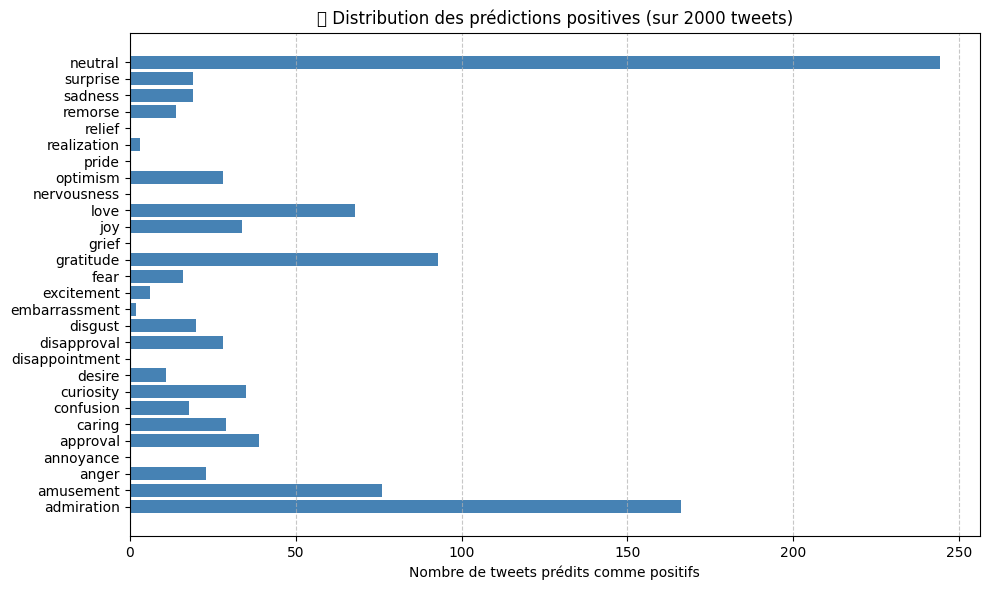

In [13]:
# Rechargement du modèle entraîné (chemin relatif depuis notebooks/)
model = AutoModelForSequenceClassification.from_pretrained("models/emotions/model")
tokenizer = AutoTokenizer.from_pretrained("models/emotions/tokenizer")
model.eval()

# Échantillon de test
df_test = df.sample(n = 2000, random_state = 70).reset_index(drop = True)
texts = df_test["text"].tolist()

# Tokenisation
encodings = tokenizer(texts, truncation = True, padding = True, return_tensors = "pt")

# Prédiction
with torch.no_grad():
    outputs = model(**encodings)

# Conversion logits → prédictions binaires
logits = outputs.logits.detach().numpy()
preds = (logits > 0).astype(int)

# Calcul du total de prédictions positives par émotion
pred_counts = preds.sum(axis=0)

# Affichage
plt.figure(figsize = (10, 6))
plt.barh(range(len(emotion_cols)), pred_counts, color = 'steelblue')
plt.yticks(ticks = range(len(emotion_cols)), labels = emotion_cols)
plt.title("📊 Distribution des prédictions positives (sur 2000 tweets)")
plt.xlabel("Nombre de tweets prédits comme positifs")
plt.grid(axis = "x", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

In [14]:
print(f"✔️ Nombre d'émotions dans emotion_cols : {len(emotion_cols)}")
print(f"✔️ Nombre de colonnes dans les prédictions : {pred_counts.shape}")

✔️ Nombre d'émotions dans emotion_cols : 28
✔️ Nombre de colonnes dans les prédictions : (28,)


## 8.2 - Comparaison VRAI vs PRÉDIT (2000 tweets)

C:\Users\motar\AppData\Local\Temp\ipykernel_21052\4263936731.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


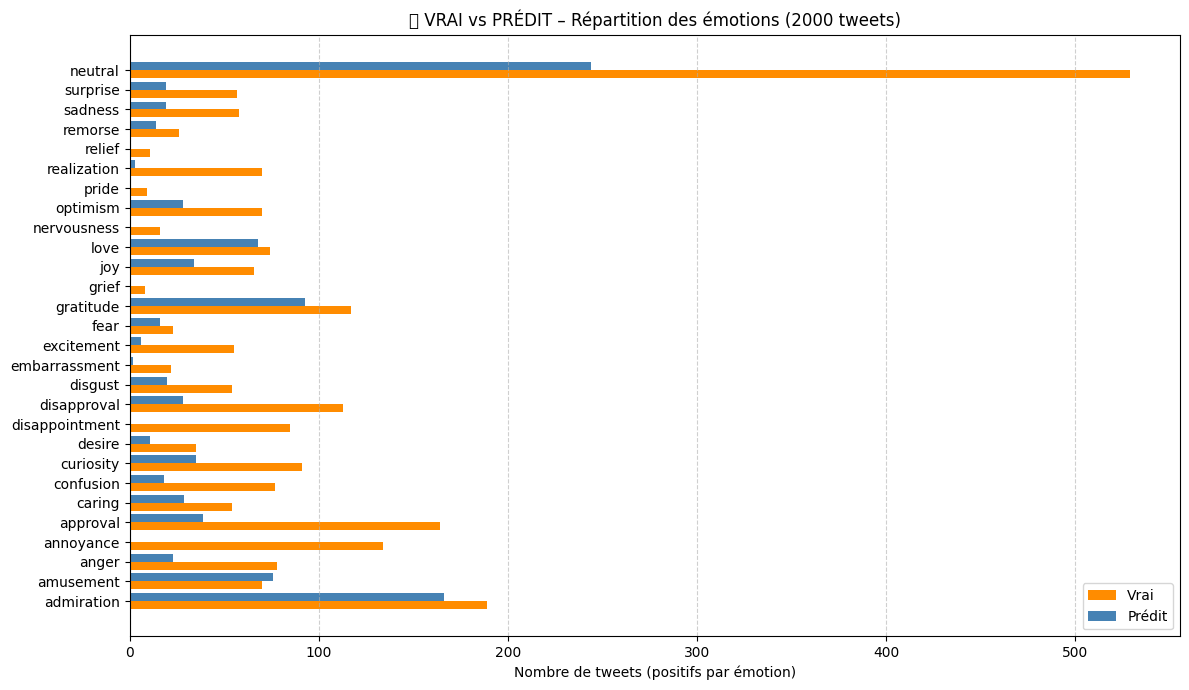

In [15]:
# Répartition réelle (ground truth)
true_counts = df_test[emotion_cols].sum().values

# Répartition des prédictions (déjà calculée précédemment)
pred_counts = preds.sum(axis=0)  # ← déjà défini

# Affichage comparatif
x = np.arange(len(emotion_cols))  # positions
width = 0.4

plt.figure(figsize=(12, 7))
plt.barh(x - width/2, true_counts, height=width, label='Vrai', color='darkorange')
plt.barh(x + width/2, pred_counts, height=width, label='Prédit', color='steelblue')

plt.yticks(ticks=x, labels=emotion_cols)
plt.xlabel("Nombre de tweets (positifs par émotion)")
plt.title("📊 VRAI vs PRÉDIT – Répartition des émotions (2000 tweets)")
plt.legend(loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 8.3 - Heatmap de co-occurrence des émotions prédites

C:\Users\motar\AppData\Local\Temp\ipykernel_21052\1794568889.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


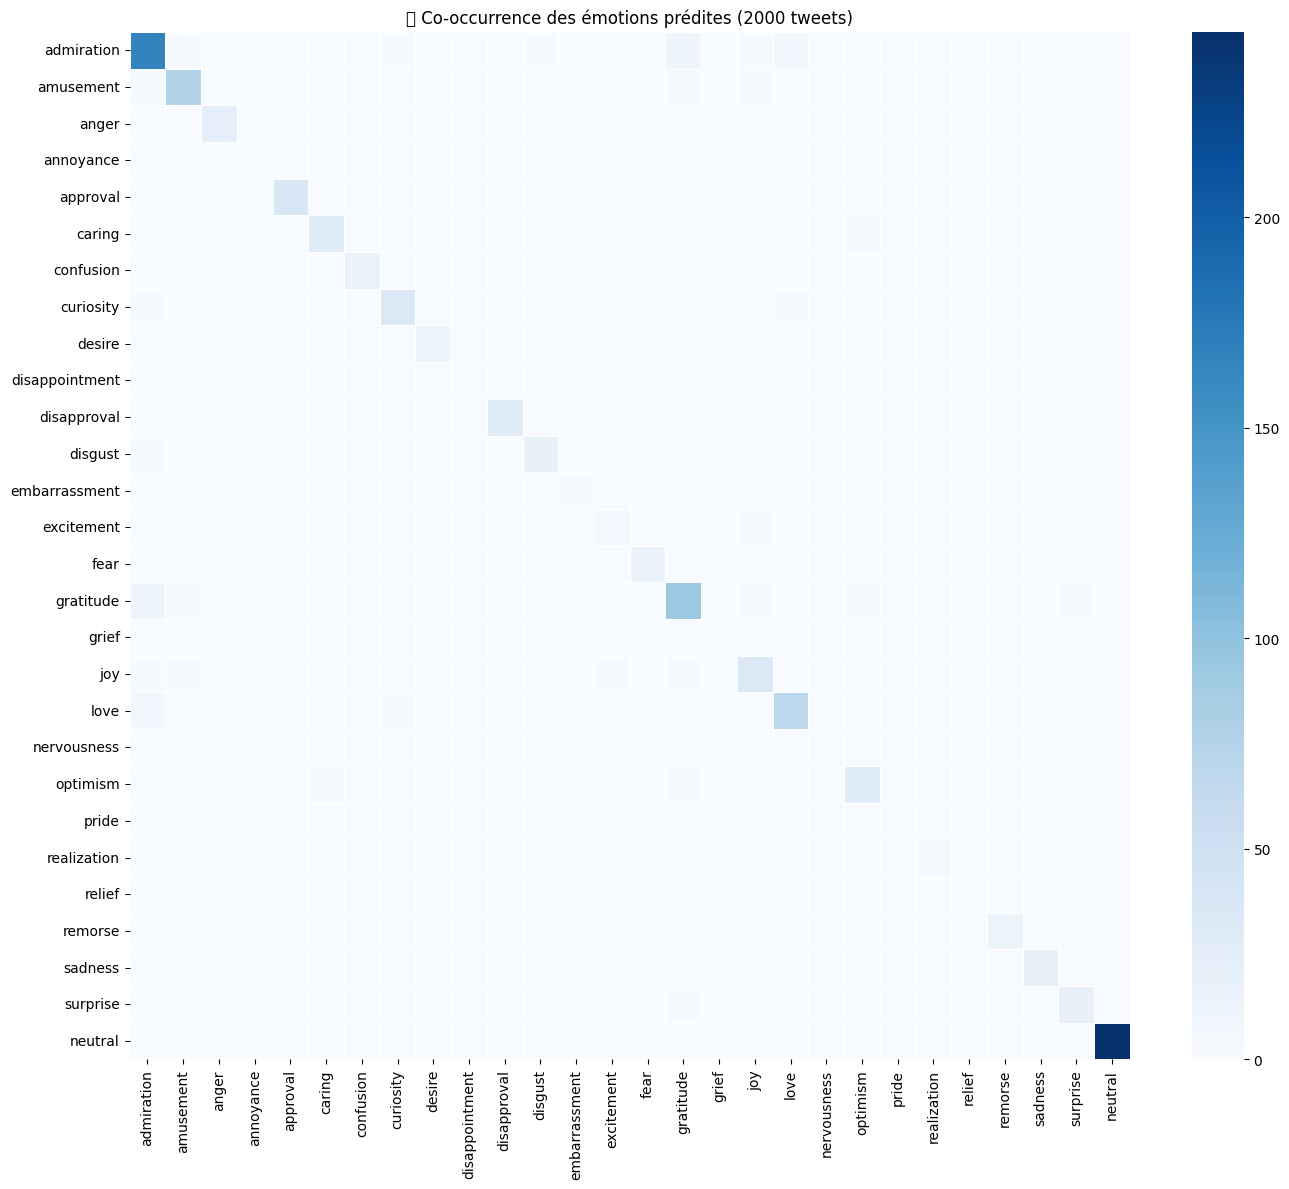

In [16]:
# Création d’une DataFrame des prédictions binaires (2000 tweets × 28 émotions)
pred_df = pd.DataFrame(preds, columns  =emotion_cols)

# Matrice de co-occurrence (corrélation binaire entre émotions)
co_matrix = pred_df.T.dot(pred_df)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, xticklabels=emotion_cols, yticklabels=emotion_cols, cmap="Blues", linewidths=0.5)
plt.title("🔥 Co-occurrence des émotions prédites (2000 tweets)")
plt.tight_layout()
plt.show()

## 8.4 - Export CSV des stats d’émotions par label

In [17]:
stats_df = pd.DataFrame({
    "emotion": emotion_cols,
    "true_count": true_counts,
    "pred_count": pred_counts,
    "difference": pred_counts - true_counts,
    "abs_error": np.abs(pred_counts - true_counts)
})

stats_df.sort_values(by="abs_error", ascending=False, inplace=True)
export_path = os.path.join("..", "outputs", "emotion_stats_2000.csv")
os.makedirs(os.path.dirname(export_path), exist_ok=True)
stats_df.to_csv(export_path, index=False, encoding="utf-8")

print(f"📁 Statistiques exportées avec succès dans : {export_path}")
display(stats_df.head(10))

📁 Statistiques exportées avec succès dans : ..\outputs\emotion_stats_2000.csv


,emotion,true_count,pred_count,difference,abs_error
27,neutral,529,244,-285,285
3,annoyance,134,0,-134,134
4,approval,164,39,-125,125
10,disapproval,113,28,-85,85
9,disappointment,85,0,-85,85
22,realization,70,3,-67,67
6,confusion,77,18,-59,59
7,curiosity,91,35,-56,56
2,anger,78,23,-55,55
13,excitement,55,6,-49,49


# 9 - Vérification des artefacts

In [18]:
print("\n🗂️ Modèles enregistrés :")
afficher_arborescence("models/emotions", niveau_max = 2)


🗂️ Modèles enregistrés :
├── checkpoint-12476
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── checkpoint-15595
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── logs
│   ├── events.out.tfevents.1746978163.PC-ARNAUD.13144.0
│   ├── events.out.tfevents.1746978485.PC-ARNAUD.26512.0
│   ├── events.out.tfevents.1746978666.PC-ARNAUD.4760.0
│   ├── events.out.tfevents.1746994927.PC-ARNAUD.4760.1
│   ├── events.out.tfevents.1746997802.PC-ARNAUD.30124.0
│   ├── events.out.tfevents.1747035152.PC-ARNAUD.30124.1
│   ├── events.out.tfevents.1747036724.PC-ARNAUD.30

## 9.1 - Interface de tracking MLflow (http://localhost:5000)

In [19]:
import subprocess

try:
    subprocess.Popen(["mlflow", "ui"])
    print("✅ MLflow UI lancé sur http://localhost:5000")
except Exception as e:
    print(f"❌ Impossible de lancer MLflow UI : {e}")

✅ MLflow UI lancé sur http://localhost:5000


In [20]:
import os
import mlflow

# 🔧 Spécifie l'URI local
mlruns_path = os.path.abspath("../mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

# 🔍 Recherche du modèle enregistré
client = mlflow.MlflowClient()
model_name = "emotions_classifier"

try:
    model = client.get_registered_model(model_name)
    print(f"✅ Modèle {model.name} trouvé avec {len(model.latest_versions)} version(s)")

    for version in model.latest_versions:
        print("📦 Version:", version.version)
        print("🔁 Run ID :", version.run_id)
        print("📂 Source :", version.source)
        print("-" * 30)

except Exception as e:
    print(f"❌ Erreur : {e}")

✅ Modèle emotions_classifier trouvé avec 3 version(s)
📦 Version: 1
🔁 Run ID : d28ed191e37a4761971a3332f9ff0a29
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/d28ed191e37a4761971a3332f9ff0a29/artifacts/emotions_model
------------------------------
📦 Version: 3
🔁 Run ID : 4589d8f9e2514c11866d287cc1c506ce
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/4589d8f9e2514c11866d287cc1c506ce/artifacts/emotions_model
------------------------------
📦 Version: 2
🔁 Run ID : 2a4098924208444baa1d3cffcc3abb70
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/2a4098924208444baa1d3cffcc3abb70/artifacts/emotions_model
------------------------------


In [21]:
# Charger les métriques
metrics = joblib.load(open("models/emotions/metrics.pkl", "rb"))

# Afficher le graphe
plot_normalized_metrics(metrics, model_name="ELECTRA – GoEmotions")

ValueError: Aucune métrique normalisée (0-1) trouvée dans les données.

# Lien vers l'application (ngrok) :
# https://f22e-2a01-cb1d-8598-1400-4ac7-ab2e-4237-81aa.ngrok-free.app